In [1]:
%load_ext autoreload
%autoreload 2
%matplotlib inline

# pylint: disable=missing-docstring
from __future__ import absolute_import
from __future__ import division
from __future__ import print_function

import os
import re
import sys
import time
import math
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt

# own python codes
sys.path.append(os.path.join(os.getcwd(), '..'))
from utils.utils import *
from utils.tf_utils import *
from cifar10_loader import CIFAR10_loader

* This TensorFlow tutorial is written based on https://github.com/tensorflow/models/tree/master/tutorials/image/cifar10, which is the tutorial for the image classification task on CIFAR-10 dataset.

이번 튜토리얼에서는 CIFAR-10 dataset에서 간단한 convolutional 네트워크를 통한 object classification을 하는 방법을 알아보자.

### Download the CIFAR-10 dataset

In [2]:
data_dir = 'cifar10_data'
data_url = 'http://www.cs.toronto.edu/~kriz/cifar-10-python.tar.gz'
maybe_download_and_extract(data_url, data_dir, 'cifar-10-batches')

### Create data loader and check the CIFAR-10 dataset
위에서 다운받은 데이터를 batch 단위로 읽어올 수 있는 data loader class를 선언. 현재 data loader는 get_batch()를 통해 단순히 이미지 및 레이블을 batch 크기만큼 받아올 수 있으며, 이미지는 특별한 preprocessing을 하지는 않는다.
하지만 보통 더 높은 성능을 위해서 random crop, flipping 등의 preprocessing을 하는 편이다.

In [2]:
loader = CIFAR10_loader()
class_names = loader.get_class_names()

None


/usr/local/lib/python2.7/dist-packages/matplotlib/figure.py:397: UserWarning: matplotlib is currently using a non-GUI backend, so cannot show the figure
  "matplotlib is currently using a non-GUI backend, "


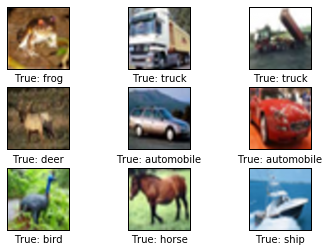

In [3]:
batch = loader.get_batch(9)
fig = plot_images(batch['images'], batch['labels'], class_names)
fig.show()

In [4]:
loader.reset() # set iterator as 0

### Functions for constructing model (graph)
Object classification을 위한 convolutional 네트워크를 선언하자. 네트워크를 선언하는 코딩 스타일은 사람마다 다르나 보통 아래와 같이 5부분 (input, model, loss, optimizer, accuracy)으로 나눠서 선언하는 경우가 많다. 
 - build_inputs(): 네트워크의 인풋을 placeholder로 선언하는 함수
 - build_model(): 네트워크의 실제 연산을 담당하는 부분으로 2개의 convolutional layer 및 2개의 fully connected layer와 classification layer로 구성된다.
 - build_loss(): 학습을 위한 loss를 정의하며 여기에서는 cross-entropy loss를 사용한다.
 - build_train_operation(): 학습을 위한 파라미터들의 gradient 계산 및 파라미터 업데이트를 하는 optimizer를 정의. 여기에서는 Adam optimizer를 사용한다.
 - build_accuracy(): 테스트를 위하여 accuracry를 정의.

In [3]:
# Get variable initialization function
initializer = get_initializer('normal', **{'stddev':0.01})

def build_inputs(batch_size, image_size):
    """ Construct input for CIFAR evaluation using the Reader ops.
    Args:
        batch_size: Batch size.
        image_size: Image size.
    Returns:
        images: Images. 4D tensor of [batch_size, IMAGE_SIZE, IMAGE_SIZE, 3] size.
        labels: Labels. 1D tensor of [batch_size] size.
    """
    with tf.variable_scope('inputs') as scope:
        images = tf.placeholder(dtype=tf.float32, shape=[batch_size, image_size, image_size, 3],
                               name='images')
        labels = tf.placeholder(dtype=tf.int64, shape=[batch_size], name='labels')
    
    return images, labels

def build_model(images, batch_size):
    """ Build the CIFAR-10 model consists of 2 convolutional, 2 fully connected and
    1 classification layer.
    Args:
        images: Images returned from build_inputs(). 4-D tensor.
    Returns:
        Logits.
    """
    
    # conv1
    with tf.variable_scope('conv1') as scope:
        conv1 = get_conv2D_layer(images, 3, 64, 5, 1, initializer, 0.0, 
                                 'relu', scope, True)
    # pool1
    pool1 = tf.nn.max_pool(conv1, ksize=[1, 2, 2, 1], strides=[1, 2, 2, 1],
                         padding='SAME', name='pool1')
    
    # conv2
    with tf.variable_scope('conv2') as scope:
        conv2 = get_conv2D_layer(pool1, 64, 64, 5, 1, initializer, 0.0, 
                                 'relu', scope, True)
    # pool2
    pool2 = tf.nn.max_pool(conv2, ksize=[1, 2, 2, 1],
                         strides=[1, 2, 2, 1], padding='SAME', name='pool2')

    # fc1
    with tf.variable_scope('fc3') as scope:
        fc3 = get_fully_connected_layer(pool2, -1, 384, initializer, 0.004, 'relu', 
                                        True, batch_size, scope, True)

    # fc2
    with tf.variable_scope('fc4') as scope:
        fc4 = get_fully_connected_layer(fc3, 384, 192, initializer, 0.004, 'relu', 
                                        False, -1, scope, True)

    # We don't apply softmax here because tf.nn.sparse_softmax_cross_entropy_with_logits 
    # accepts the unscaled logits and performs the softmax internally for efficiency.
    with tf.variable_scope('fc5') as scope:
        logits = get_fully_connected_layer(fc4, 192, loader.get_num_classes(), initializer, 
                                           0.0, 'None', False, -1, scope, True)

    return logits

def build_loss(logits, labels):
    """ Add L2Loss to all the trainable variables.
    Add summary for "Loss" and "Loss/avg".
    Args:
        logits: Logits from build_model().
        labels: Labels from build_inputs(). 1-D tensor.
    Returns:
        Loss tensor of type float.
    """
    # Calculate the average cross entropy loss across the batch.
    labels = tf.cast(labels, tf.int64)
    cross_entropy = tf.nn.sparse_softmax_cross_entropy_with_logits(
        labels=labels, logits=logits, name='cross_entropy_per_example')
    cross_entropy_mean = tf.reduce_mean(cross_entropy, name='cross_entropy')
    tf.add_to_collection('losses', cross_entropy_mean)

    # The total loss is defined as the cross entropy loss plus all 
    # of the weight decay terms (L2 loss).
    return tf.add_n(tf.get_collection('losses'), name='total_loss')

def build_train_operation(total_loss, params):
    """ Train CIFAR-10 model and create an optimizer.
    Args:
        total_loss: Total loss from loss().
        params: parameters for exponential decaying. 
                The learning rate is computed by 
                decayed_learning_rate = initial_lr * 
                    decay_rate ^ (global_step / decay_steps)
            - initial_lr: initial learning rate
            - decay_step: decay step
            - decay_rate: decay rate
    Returns:
        train_op: op for training.
        global_step: global step counting iteration
    """
    # Decay the learning rate exponentially based on the number of steps.
    global_step = tf.Variable(initial_value=0, name='global_step', trainable=False)
    lr = tf.train.exponential_decay(params['initial_lr'],
                                    global_step,
                                    params['decay_step'],
                                    params['decay_rate'],
                                    staircase=True)
    
    # Create the optimizer which will minimize the loss.
    # Below two methods are equivalent. But, when you want to process
    # the gradients before updating a model, second method is appropriate.
    if params['use_minimize']:
        train_op = tf.train.AdamOptimizer(lr).minimize(total_loss, global_step=global_step)
        return train_op, global_step
    else:
        optimizer = tf.train.AdamOptimizer(lr)
        # Compute the gradients
        grads_and_vars = optimizer.compute_gradients(total_loss)
        # TODO: clipping the gradients
        
        # Updating the model
        train_op = optimizer.apply_gradients(grads_and_vars, global_step=global_step)
        
        return train_op, global_step, grads_and_vars
    

def build_accuracy(logits, labels):
    """ Accuarcy computed by
        accuracy = # of correct examples / # of total examples
    Args:
        logits: Logits from build_model().
        labels: Labels from build_model().
    Returns:
        accuracy: Accuracy.
        correct_num: The number of corrected examples
        pred_labels: Predicted labels by the model
    """
    pred_labels = tf.argmax(logits, axis=1)
    correct_prediction = tf.equal(pred_labels, tf.cast(labels, tf.int64))
    correct_num = tf.reduce_sum(tf.cast(correct_prediction, tf.float32))
    accuracy = tf.reduce_mean(tf.cast(correct_prediction, tf.float32))
    
    return accuracy, correct_num, pred_labels

### Training the model

모델 학습을 위한 파라미터 정의

In [4]:
# Model parameters
init_from = '' # checkpoint path
save_path = 'cifar10_checkpoints/cifar10_cnn'
if not os.path.exists('cifar10_checkpoints'): os.makedirs('cifar10_checkpoints')
batch_size = 100
num_epochs = 20
iteration_per_epoch = int(math.floor(loader.get_num_train_examples() / batch_size))
save_checkpoint_frequency = 500
print_frequency = 100

# Model updating parameters
lr_params = {}
lr_params['initial_lr'] = 0.001
lr_params['decay_step'] = 10000
lr_params['decay_rate'] = 0.8
lr_params['use_minimize'] = False

모델 정의

In [55]:
"""Train CIFAR-10 for a number of steps."""

# build input placeholders
images, labels = build_inputs(batch_size, loader.get_image_size())

# Build a Graph that computes the logits predictions from the
# inference model.
logits = build_model(images, batch_size)

# Calculate loss.
loss = build_loss(logits, labels)

# Build a Graph that trains the model with one batch of examples and
# updates the model parameters.
if lr_params['use_minimize']:
    train_op, global_step = build_train_operation(loss, lr_params)
else:
    train_op, global_step, grads_vars = build_train_operation(loss, lr_params)

# Build the accuracy and correct number of examples
# to check model is learned correctly while training
accuracy, correct_num, prediction = build_accuracy(logits, labels)

In [54]:
# This has been commented out in case you want to modify and experiment
# with the Notebook without having to restart it.
tf.reset_default_graph()
sess.close()

모델을 저장하고 추후 읽어오기 위한 saver를 정의하고, 모델을 실행 할 session을 생성 및 모델의 weight를 초기화

In [57]:
# Create Saver-object to save and reload the model later
saver = tf.train.Saver()

# Create session
sess = tf.Session(config=tf.ConfigProto(allow_soft_placement=True,log_device_placement=True))

# Initialize the variables
sess.run(tf.global_variables_initializer())

정의한 모델을 구성하는 layer 및 그 name을 확인하는 방법을 알아보자. 또한, 특정 variable을 얻고 그 값을 확인하는 방법을 알아보자.

In [49]:
print('The list of variables (or layers) in the model:')
for var in tf.global_variables():
    print(var)
    #print(var.op.name)

The list of variables (or layers) in the model:
Tensor("conv1/weights/read:0", shape=(5, 5, 3, 64), dtype=float32)
Tensor("conv1/biases/read:0", shape=(64,), dtype=float32)
Tensor("conv2/weights/read:0", shape=(5, 5, 64, 64), dtype=float32)
Tensor("conv2/biases/read:0", shape=(64,), dtype=float32)
Tensor("fc3/weights/read:0", shape=(1600, 384), dtype=float32)
Tensor("fc3/biases/read:0", shape=(384,), dtype=float32)
Tensor("fc4/weights/read:0", shape=(384, 192), dtype=float32)
Tensor("fc4/biases/read:0", shape=(192,), dtype=float32)
Tensor("fc5/weights/read:0", shape=(192, 10), dtype=float32)
Tensor("fc5/biases/read:0", shape=(10,), dtype=float32)
Tensor("global_step/read:0", shape=(), dtype=int32)
Tensor("beta1_power/read:0", shape=(), dtype=float32)
Tensor("beta2_power/read:0", shape=(), dtype=float32)
Tensor("conv1/weights/Adam/read:0", shape=(5, 5, 3, 64), dtype=float32)
Tensor("conv1/weights/Adam_1/read:0", shape=(5, 5, 3, 64), dtype=float32)
Tensor("conv1/biases/Adam/read:0", shap

중간 레이어 결과값 혹은 사이즈 확인

In [50]:
cc = sess.run('conv1/conv1_out:0', feed_dict={images:loader.get_batch(batch_size, 'train')['images']})
print(cc.shape)

(100, 28, 28, 64)


In [51]:
cc = sess.run('conv2/conv2_out:0', feed_dict={images:loader.get_batch(batch_size, 'train')['images']})
print(cc.shape)

(100, 10, 10, 64)


모델의 파라미터 확인

In [52]:
logit_weight = tf.get_default_graph().get_tensor_by_name('fc5/weights/read:0')
logit = logit_weight.eval(session=sess)
print(logit.shape)
print(logit[0,:10])
print(sess.run(logit_weight)[0,:10])

(192, 10)
[ 0.00417436  0.01035099  0.00198316  0.00643856  0.00888029  0.00903297
 -0.0122347  -0.01635222 -0.01234471  0.00342033]
[ 0.00417436  0.01035099  0.00198316  0.00643856  0.00888029  0.00903297
 -0.0122347  -0.01635222 -0.01234471  0.00342033]


모델 학습

In [58]:
# Train the model
for ie in range(num_epochs):
    for ii in range(iteration_per_epoch):
        # Load a batch data
        batch = loader.get_batch(batch_size, 'train')

        # Run the optimizer
        iteration, _ = sess.run([global_step, train_op], 
                                             feed_dict={images:batch['images'],
                                                        labels:batch['labels']})

        # Print the accuracy and loss of current batch data
        if iteration % print_frequency == 0:
            batch_loss, batch_acc = sess.run([loss, accuracy], 
                                             feed_dict={images:batch['images'],
                                                        labels:batch['labels']})
            print('%d Epoch %d iteration - Loss (%.3f) Accuracy (%.3f)' 
                      %(ie+1, ii+1, batch_loss, batch_acc))

        # Save checkpoint
        if iteration % save_checkpoint_frequency == 0:
            saver.save(sess, save_path=save_path, global_step=global_step)
            print('Saved checkpoint %s_%d' % (save_path, iteration))

1 Epoch 100 iteration - Loss (2.011) Accuracy (0.240)
1 Epoch 200 iteration - Loss (2.113) Accuracy (0.250)
1 Epoch 300 iteration - Loss (1.805) Accuracy (0.310)
1 Epoch 400 iteration - Loss (1.775) Accuracy (0.330)
1 Epoch 500 iteration - Loss (1.615) Accuracy (0.450)
Saved checkpoint cifar10_checkpoints/cifar10_cnn_500
2 Epoch 100 iteration - Loss (1.576) Accuracy (0.470)
2 Epoch 200 iteration - Loss (1.687) Accuracy (0.400)
2 Epoch 300 iteration - Loss (1.336) Accuracy (0.530)
2 Epoch 400 iteration - Loss (1.574) Accuracy (0.380)
2 Epoch 500 iteration - Loss (1.409) Accuracy (0.530)
Saved checkpoint cifar10_checkpoints/cifar10_cnn_1000
3 Epoch 100 iteration - Loss (1.377) Accuracy (0.560)
3 Epoch 200 iteration - Loss (1.644) Accuracy (0.460)
3 Epoch 300 iteration - Loss (1.263) Accuracy (0.570)
3 Epoch 400 iteration - Loss (1.492) Accuracy (0.430)
3 Epoch 500 iteration - Loss (1.342) Accuracy (0.550)
Saved checkpoint cifar10_checkpoints/cifar10_cnn_1500
4 Epoch 100 iteration - Loss 

In [32]:
tf.reset_default_graph()
sess.close()

### Evaluating the model

In [5]:
# Manually set the checkpoint path
#checkpoint_path = 'cifar10_checkpoints/cifar10_cnn-5000'
# Automatically find the last checkpoint
checkpoint_path = tf.train.latest_checkpoint(checkpoint_dir='cifar10_checkpoints/')
print('Last checkpoint path is %s' % (checkpoint_path))

Last checkpoint path is cifar10_checkpoints/cifar10_cnn-10000


In [6]:
"""Evaluation model"""
# build input placeholders
images, labels = build_inputs(batch_size, loader.get_image_size())

# Build a Graph that computes the logits predictions from the
# inference model.
logits = build_model(images, batch_size)

# Calculate loss.
loss = build_loss(logits, labels)

# Build a Graph that trains the model with one batch of examples and
# updates the model parameters.
if lr_params['use_minimize']:
    train_op, global_step = build_train_operation(loss, lr_params)
else:
    train_op, global_step, grads_vars = build_train_operation(loss, lr_params)

# Build the accuracy and correct number of examples
# to check model is learned correctly while training
accuracy, correct_num, prediction = build_accuracy(logits, labels)

# Create Saver-object to save and reload the model later
saver = tf.train.Saver()

with tf.Session(config=tf.ConfigProto(allow_soft_placement=True,
                                     log_device_placement=True)) as sess:
    # Load the checkpoint or initialize the variables
    if checkpoint_path != '':
        saver.restore(sess, save_path=checkpoint_path)
        print('Model is restored from %s' % checkpoint_path)
    else:
        sess.run(tf.global_variables_initializer())

    # Evaluate the model
    num_correct = 0
    num_examples = 0    
    while True:
        # Load a batch data
        batch = loader.get_batch(batch_size, 'test')
        if batch['wrapped']: break

        # Compute the correct numbers
        batch_acc, batch_correct_num = sess.run([accuracy, correct_num], 
                                            feed_dict={images:batch['images'],
                                                       labels:batch['labels']})

        num_correct += batch_correct_num
        num_examples += batch_size
    print('Test accuracy: %.2f%%' % (num_correct / num_examples * 100.0))

Model is restored from cifar10_checkpoints/cifar10_cnn-10000
Test accuracy: 66.34%


Plot the images and predicted & true labels

In [9]:
sess = tf.Session()
saver.restore(sess, save_path=checkpoint_path)

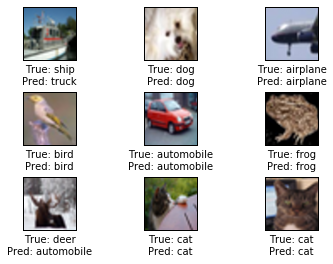

In [21]:
batch = loader.get_batch(batch_size, 'test')
realized_prediction = sess.run([prediction], feed_dict={images:batch['images'],labels:batch['labels']})
fig = plot_images(batch['images'][:9], batch['labels'][:9], loader.get_class_names(), realized_prediction[0][:9])
fig.show()

In [ ]:
tf.reset_default_graph()
sess.close()